# day02 : Short Intro to PyTorch : CS 152 L3D

www.cs.tufts.edu/cs/152L3D/2024f/

Goals:
* Learn how to use PyTorch library to load pretrained models and evaluate on custom classification tasks
* Learn how to *train* neural networks with PyTorch

Outline:

* Part 1: Images in PyTorch
* Part 2: Predictions with pretrained models
* Part 3: Training models

### Import required libraries

In [1]:
import numpy as np
import pandas as pd

import os
import sys

In [2]:
import sklearn.model_selection
import sklearn.metrics

In [3]:
import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision
from torchvision import transforms

In [5]:
torch.__version__

'2.4.0+cu121'

In [6]:
torch.cuda.is_available()

True

In [7]:
try:
    import torchinfo
except ImportError:
    !pip install torchinfo
    import torchinfo

Prepare facts about ImageNet dataset

In [8]:
# Mean/stddev of R/G/B image channels for ImageNet
mu_ImageNet_3 = [0.485, 0.456, 0.406]
std_ImageNet_3 = [0.229, 0.224, 0.225]

In [9]:
# Download names of the 1000 classes in ImageNet
if not os.path.exists("imagenet_classes.txt"):
    !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    cat_names_C = [s.strip() for s in f.readlines()]

print("Model is aware of %d classes" % len(cat_names_C))
print(cat_names_C[:5])
print(cat_names_C[-5:])

Model is aware of 1000 classes
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']
['earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


## Part 1: Representing images in NumPy / PyTorch

Download example image of a dog from the pytorch website


In [10]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

### 1a: Image as nd-array in NumPy

Load image into NumPy array. Verify the type, shape, and dtype.

In [11]:
im_HW3 = plt.imread(filename, format='jpg')

print(type(im_HW3))
print("shape: ", im_HW3.shape)
print("dtype: ", im_HW3.dtype)

<class 'numpy.ndarray'>
shape:  (1213, 1546, 3)
dtype:  uint8


Visualize the image using matplotlib's imshow command

We should see a color image with 1213 rows and 1546 cols

Docs: <https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html>


In [12]:
plt.imshow(im_HW3);

Look at the first 6 rows/cols of the "red" channel

In [13]:
%matplotlib inline
plt.plot([1,2,3])

In [14]:
print(im_HW3[:6, :6, 0])

[[13 17 15 10 20 14]
 [16 18 15 11 19 12]
 [17 18 17 14 19 13]
 [13 13 14 16 17 14]
 [ 7  7 10 16 14 12]
 [ 7  6 10 14  8 13]]


Look at the max value across all channels and all pixels

In [15]:
im_HW3.max()

255

Recall that the dtype is `uint8'. This is an unsigned integer with 8 bits. Here, unsigned means we cannot represent negative values.

Thus, there are 2^8 = 256 possible values, ranging over the non-negative integers: starting at 0 and counting up 1, 2, 3, and so on.

Thus, the minimum value is 0, and maximum is 255.

### 1b: Handling image as PyTorch tensor

PyTorch tends to work well the Python image library (PIL). PIL utilities handle raw image representation.

In [16]:
from PIL import Image
input_image = Image.open(filename)

We can convert the PIL image to a **Tensor** in PyTorch.

Each Tensor object has a `shape` and a `dtype` attribute, just like an nd-array in numpy

Note the default ordering in PyTorch is to have the color channel  **first**, then height, then width.


In [17]:
rawim_torch_3HW = torchvision.transforms.PILToTensor()(input_image)

print(type(rawim_torch_3HW))
print("shape:", rawim_torch_3HW.shape)
print("dtype:", rawim_torch_3HW.dtype)
print("minval:", rawim_torch_3HW.min())
print("maxval:", rawim_torch_3HW.max())


<class 'torch.Tensor'>
shape: torch.Size([3, 1213, 1546])
dtype: torch.uint8
minval: tensor(0, dtype=torch.uint8)
maxval: tensor(255, dtype=torch.uint8)


Printing out the first 6x6 block of the red channel, we should get the same raw information as we did with NumPy above

In [18]:
rawim_torch_3HW[0, :6, :6]

tensor([[13, 17, 15, 10, 20, 14],
        [16, 18, 15, 11, 19, 12],
        [17, 18, 17, 14, 19, 13],
        [13, 13, 14, 16, 17, 14],
        [ 7,  7, 10, 16, 14, 12],
        [ 7,  6, 10, 14,  8, 13]], dtype=torch.uint8)

We can do mathematical operations on the tensor just like we would in NumPy

In [19]:
torch.sum(rawim_torch_3HW, axis=[1,2])

tensor([185780582, 206248139, 175866146])

Can easily convert the Tensor to a NumPy array of equivalent shape / dtype

In [20]:
torch.sum(rawim_torch_3HW, axis=[1,2]).numpy()

array([185780582, 206248139, 175866146])

### 1c: Preprocessing images to standard size

When we need to feed images into neural nets, we usually need to provide a standardized size (fixed height/width).

The composed set of basic transforms below will build a function that

* Resizes the image (maintaining aspect ratio) so the smallest dimension is 256. For our dog image, it has W > H, so the image will be rescaled from shape (H,W) to (256, 256 * W/H). [see transforms.Resize docs](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize)

* Crop the image to keep the 224x224 image in the *center*.

* Convert the resulting image into a PyTorch tensor of shape (3, 224, 224)



In [21]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),  # convert to float32 dtype, vals between 0. and 1.
])

In [22]:
im_torch_3HW = preprocess(input_image)


In [23]:
type(im_torch_3HW)
print("shape:", im_torch_3HW.shape)
print("dtype:", im_torch_3HW.dtype)
print("minval:", im_torch_3HW.min())
print("maxval:", im_torch_3HW.max())

shape: torch.Size([3, 224, 224])
dtype: torch.float32
minval: tensor(0.0039)
maxval: tensor(1.)


In [24]:
im_torch_3HW[0, :6, :6]

tensor([[0.0431, 0.0431, 0.0471, 0.0510, 0.0314, 0.0275],
        [0.0275, 0.0510, 0.0471, 0.0392, 0.0275, 0.0196],
        [0.0275, 0.0392, 0.0471, 0.0314, 0.0118, 0.0157],
        [0.0314, 0.0471, 0.0471, 0.0196, 0.0157, 0.0275],
        [0.0196, 0.0431, 0.0627, 0.0353, 0.0235, 0.0314],
        [0.0275, 0.0275, 0.0392, 0.0353, 0.0275, 0.0314]])

In [25]:
plt.imshow(im_torch_3HW.permute(1,2,0));

Reshape our image array so it has shape (batch_size, 3, H, W), with batch_size=1
This makes an image that is able to be fed into typical PyTorch neural nets

See [docs for `unsqueeze`](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html)

In [26]:
im_torch_13HW = im_torch_3HW.unsqueeze(0) # add "dummy" dimension

im_torch_13HW.shape

torch.Size([1, 3, 224, 224])

# Part 2: Working with pretrained models in PyTorch

AlexNet architecture is documented here: <https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py>



In [27]:
torch.cuda.is_available()

True

Define utility function for inspecting a PyTorch model

In [28]:
def pretty_print_param_tensors_of_each_layer(model):
    print("Listing of individual layer weight/bias parameters")
    print("%-20s %-20s %-15s %-12s" % ("key", "shape", "min", "max"))

    sdict = model.state_dict()
    for tensor_name, tensor in sdict.items():
        print("%-20s %-20s % 10.5f % 10.5f" % (
            tensor_name, tuple(tensor.shape),
            tensor.min().cpu().numpy(),
            tensor.max().cpu().numpy()))

### 2a: Load a "default" AlexNet, understand its structure

In [29]:
default_alexnet = torch.hub.load('pytorch/vision:v0.19.0', 'alexnet')
print(type(default_alexnet))

Using cache found in /cluster/home/mhughe02/.cache/torch/hub/pytorch_vision_v0.19.0


<class 'torchvision.models.alexnet.AlexNet'>


In [30]:
input_shape = (1,3,224,224)
torchinfo.summary(default_alexnet, input_shape,
                  row_settings=['var_names'],
                  col_names=["kernel_size", "output_size", "num_params"],
                  col_width=18)


Layer (type (var_name))                  Kernel Shape       Output Shape       Param #
AlexNet (AlexNet)                        --                 [1, 1000]          --
├─Sequential (features)                  --                 [1, 256, 6, 6]     --
│    └─Conv2d (0)                        [11, 11]           [1, 64, 55, 55]    23,296
│    └─ReLU (1)                          --                 [1, 64, 55, 55]    --
│    └─MaxPool2d (2)                     3                  [1, 64, 27, 27]    --
│    └─Conv2d (3)                        [5, 5]             [1, 192, 27, 27]   307,392
│    └─ReLU (4)                          --                 [1, 192, 27, 27]   --
│    └─MaxPool2d (5)                     3                  [1, 192, 13, 13]   --
│    └─Conv2d (6)                        [3, 3]             [1, 384, 13, 13]   663,936
│    └─ReLU (7)                          --                 [1, 384, 13, 13]   --
│    └─Conv2d (8)                        [3, 3]             [1, 256, 13, 13]   

Use our provided utility function to describe layer-by-layer parameters, stored as tensors within the state_dict of the AlexNet object.

In [31]:
pretty_print_param_tensors_of_each_layer(default_alexnet)


Listing of individual layer weight/bias parameters
key                  shape                min             max         
features.0.weight    (64, 3, 11, 11)        -0.05248    0.05249
features.0.bias      (64,)                  -0.05108    0.05029
features.3.weight    (192, 64, 5, 5)        -0.02500    0.02500
features.3.bias      (192,)                 -0.02474    0.02496
features.6.weight    (384, 192, 3, 3)       -0.02406    0.02406
features.6.bias      (384,)                 -0.02405    0.02395
features.8.weight    (256, 384, 3, 3)       -0.01701    0.01701
features.8.bias      (256,)                 -0.01698    0.01695
features.10.weight   (256, 256, 3, 3)       -0.02083    0.02083
features.10.bias     (256,)                 -0.02061    0.02077
classifier.1.weight  (4096, 9216)           -0.01042    0.01042
classifier.1.bias    (4096,)                -0.01041    0.01042
classifier.4.weight  (4096, 4096)           -0.01562    0.01562
classifier.4.bias    (4096,)                -0

Look at the bias values for the first 10 classes in last layer of classifier

In [32]:
print(default_alexnet.state_dict()['classifier.6.bias'].cpu().numpy()[:10])

[-0.00085829 -0.01333406 -0.00272938 -0.01445399 -0.00775673  0.00372595
 -0.01212063 -0.00374217 -0.00954222 -0.00678362]


### 2b: AlexNet pretrained on ImageNet

A valuable resource for pretrained neural nets is the PyTorch vision hub

<https://pytorch.org/vision/stable/models.html#general-information-on-pre-trained-weights>

We'll use an AlexNet pretrained on ImageNet, as described in this paper

<https://arxiv.org/abs/1404.5997>

In particular, the recipe for training is described here: https://github.com/pytorch/vision/tree/main/references/classification#alexnet-and-vgg, and is intended for use on 8 nVidia V100 GPUs

On the ImageNet1k test set, this model gets the following scores:

* top-1 acc of 56.52%
* top-5 acc of 79.07%

In [33]:
from torchvision.models.alexnet import AlexNet_Weights # import metadata about the pretrained model

In [34]:
for propname in ['num_params', 'min_size', '_metrics']:
    print(propname, AlexNet_Weights.IMAGENET1K_V1.meta.get(propname))

num_params 61100840
min_size (63, 63)
_metrics {'ImageNet-1K': {'acc@1': 56.522, 'acc@5': 79.066}}


Load the actual model, using the provided info from  AlexNet_Weights object

In [35]:
pretrained_alexnet = torch.hub.load('pytorch/vision:v0.19.0', 'alexnet',
                       source='github',
                       weights=AlexNet_Weights.IMAGENET1K_V1)


Using cache found in /cluster/home/mhughe02/.cache/torch/hub/pytorch_vision_v0.19.0


In [36]:
pretrained_alexnet.eval(); # Set evaluation mode, which impacts dropout, batchnorm, etc.

In [37]:
pretty_print_param_tensors_of_each_layer(pretrained_alexnet)

Listing of individual layer weight/bias parameters
key                  shape                min             max         
features.0.weight    (64, 3, 11, 11)        -0.78192    0.93540
features.0.bias      (64,)                  -2.80696    1.64538
features.3.weight    (192, 64, 5, 5)        -0.83417    2.22697
features.3.bias      (192,)                 -0.47721    0.49935
features.6.weight    (384, 192, 3, 3)       -0.67115    0.85562
features.6.bias      (384,)                 -0.42012    0.55266
features.8.weight    (256, 384, 3, 3)       -0.33061    0.38850
features.8.bias      (256,)                 -1.42644    0.90375
features.10.weight   (256, 256, 3, 3)       -0.22604    0.21544
features.10.bias     (256,)                 -0.45605    2.40212
classifier.1.weight  (4096, 9216)           -0.07038    0.06490
classifier.1.bias    (4096,)                -0.07082    0.09408
classifier.4.weight  (4096, 4096)           -0.10437    0.08242
classifier.4.bias    (4096,)                -0

### 2c: Wrapper class simplifying preprocessing of images and pretty-display of predictions


Key parts of *preprocessing*:

* Assume raw image is a tensor with float values between 0.0 and 1.0
* Need to normalize the R/G/B channels, so resulting image pixel value at channel $c$ has value  $\tilde{x}_c = \frac{ x_c - \mu_c}{\sigma_c}$, where $\mu_c$ and $\sigma_c$ are the mean/stddev of that channel on the ImageNet training data

Key parts of **prediction**:

* Want to easily display the "top K" most probable classes, with associated probabilities.
* We will use pandas dataframes, as they allow easy display of numerical values with associated string labels

In [38]:
class MyAlexNet(object):

    def __init__(self, pretrained='imagenet'):
        if pretrained.lower().count('imagenet'):
            self.model = torch.hub.load(
                'pytorch/vision:v0.19.0', 'alexnet',
                source='github', weights=AlexNet_Weights.IMAGENET1K_V1)
        else:
            self.model = torch.hub.load(
                'pytorch/vision:v0.19.0', 'alexnet',
                weights=None)
        if torch.cuda.is_available():
            self.model.to('cuda')

    def predict_proba(self, x_B3HW,
                      normalize_RGB=True,
                      keep_topk_classes_only=False, K=5):
        ''' Predict probability of ImageNet classes for provided batch of images

        Returns
        -------
        proba_BC : 2D array, shape (B = batch_size, C = num_classes)
        '''
        self.model.eval() # in evaluation mode
        if torch.cuda.is_available():
            x_B3HW = x_B3HW.to('cuda')
        if normalize_RGB:
            x_B3HW = transforms.functional.normalize(
                x_B3HW, mu_ImageNet_3, std_ImageNet_3)
        with torch.no_grad():
            out_logits_BC = self.model.forward(x_B3HW)
            out_proba_BC = torch.nn.functional.softmax(out_logits_BC, dim=1)
        if torch.cuda.is_available():
            out_proba_BC = out_proba_BC.cpu().detach()
        if keep_topk_classes_only:
            if x_B3HW.shape[0] != 1:
                raise ValueError("Cannot keep topk for multiple images")
            top_proba_BK, top_catid_BK = torch.topk(out_proba_BC, K)
            out_df = pd.DataFrame(top_proba_BK.numpy(),
                                  columns=[cat_names_C[int(c)]
                                           for c in top_catid_BK[0]])
        else:
            out_df = pd.DataFrame(out_proba_BC.numpy(), columns=cat_names_C)

        return out_df


In [39]:
alexnet = MyAlexNet(pretrained='imagenet')


Using cache found in /cluster/home/mhughe02/.cache/torch/hub/pytorch_vision_v0.19.0


In [40]:
dogim_torch_13HW = im_torch_3HW.unsqueeze(0)

Let's make a prediction using the example fluffy dog image.

In [41]:
alexnet.predict_proba(dogim_torch_13HW)

,tench,goldfish,great white shark,tiger shark,hammerhead,electric ray,stingray,cock,hen,ostrich,...,buckeye,coral fungus,agaric,gyromitra,stinkhorn,earthstar,hen-of-the-woods,bolete,ear,toilet tissue
0,6.839687e-09,4.608231e-10,5.804324e-09,5.280623e-10,1.468728e-09,5.027137e-08,1.060063e-07,0.000014,0.000111,1.769670e-08,...,2.969121e-08,1.883545e-08,3.199920e-08,9.768255e-09,2.796309e-09,6.481327e-07,2.159485e-09,1.372333e-09,8.705586e-08,3.647928e-07


Inspect top-5 predictions for example dog image

Note: the dog is definitely an example of a dog breed known as a **Samoyed**

<https://en.wikipedia.org/wiki/Samoyed_dog>

In [42]:
print(alexnet.predict_proba(
    dogim_torch_13HW,
    keep_topk_classes_only=True, K=5))

    Samoyed   wallaby  Pomeranian   Angora  Arctic fox
0  0.724477  0.139379     0.05875  0.02283     0.01245


<br />

Let's verify that preprocessing with the per-channel mean/stddev matters. We'll try to make predictions without that preprocessing, and see what happens... do we get the same probability on the true class?

In [43]:
print(alexnet.predict_proba(
    im_torch_13HW,
    normalize_RGB=False,
    keep_topk_classes_only=True, K=5))

    Samoyed   Angora  Arctic fox  West Highland white terrier  Persian cat
0  0.422879  0.16183    0.056778                     0.051236      0.03076


### 2d: Apply classifier to the Pets6 dataset

Plan for this subsection: 

* download the [Oxford-IIIT Pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)
* build a special subset we'll call Pets-6, of 6 classes (3 dog and 3 cat breeds) that overlap with known classes in ImageNet1k
* evaluate pretrained AlexNet classifier and see how well it does on this 6-way classification task

First, download the data

In [44]:
pet_data = torchvision.datasets.OxfordIIITPet(
    ".", download=True, split='trainval', transform=preprocess)

In [45]:
pet2imagenet = {
    'Pomeranian':'Pomeranian',
    'Great Pyrenees':'Great Pyrenees',
    'Samoyed':'Samoyed',
    'Egyptian Mau':'Egyptian cat',
    'Persian': 'Persian cat',
    'Siamese': 'Siamese cat',
}

In [46]:
# Sanity check: verify the desired class names occur in both datasets
for k, v in pet2imagenet.items():
    print(v, pet_data.classes.index(k), cat_names_C.index(v))

Pomeranian 24 259
Great Pyrenees 15 257
Samoyed 29 258
Egyptian cat 11 285
Persian cat 23 283
Siamese cat 32 284


In [47]:
J = 6 # num of target classes in our Pets-6 dataset

Load subset of train data with 100 examples of each target class (might take 30 sec or so)


In [48]:
keep_pet_catnames = [k for k in pet2imagenet.keys()]
keep_pet_catids = [pet_data.classes.index(s) for s in keep_pet_catnames]
N_J = np.zeros(J, dtype=np.int32)
keep_x_list = list()
keep_y_list = list()
MAX_PER_CLASS = 100
for x, y in pet_data:
    if y in keep_pet_catids:
        catid = keep_pet_catids.index(y)
        if N_J[catid] < MAX_PER_CLASS:
            keep_x_list.append(x.unsqueeze(0))
            keep_y_list.append(y)
            N_J[catid] += 1
    if np.allclose(N_J, MAX_PER_CLASS):
         break

In [49]:
print(N_J)

[100 100 100  93 100  99]


In [50]:
x_M3HW = torch.vstack(keep_x_list)
y_M = torch.tensor(keep_y_list)

M = len(keep_y_list)
N = M // 2

In [51]:
x_tr_N3HW, x_va_N3HW, y_tr_N, y_va_N = sklearn.model_selection.train_test_split(
    x_M3HW, y_M,
    test_size=N, random_state=1234, shuffle=True, stratify=y_M)

In [52]:
np.unique(y_tr_N, return_counts=True)

(array([11, 15, 23, 24, 29, 32]), array([46, 50, 50, 50, 50, 50]))

In [53]:
np.unique(y_va_N, return_counts=True)

(array([11, 15, 23, 24, 29, 32]), array([47, 50, 50, 50, 50, 49]))

Visualize the top-4 predicted classes for several example images of each category

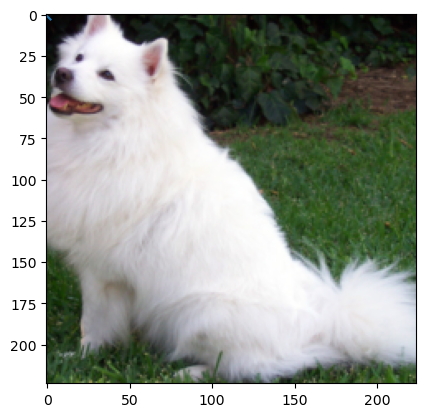

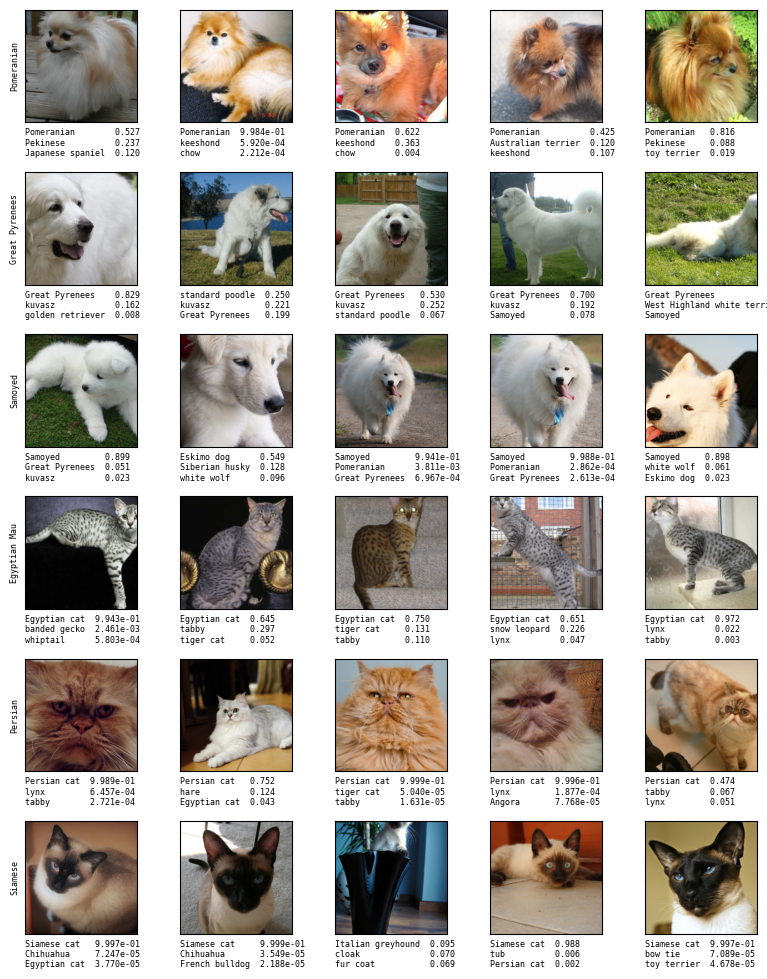

In [54]:
n_to_show = 5
_, axgrid = plt.subplots(nrows=J, ncols=n_to_show, figsize=(2*n_to_show, 2*J))

pd.set_option('display.precision', 3)

for cc, cat_name in enumerate(keep_pet_catnames):
    # Pick some random examples of this class
    match_ids = np.flatnonzero(y_tr_N == keep_pet_catids[cc])
    chosen_ids = np.random.RandomState(42).choice(match_ids, n_to_show, replace=False)
    for ii, nn in enumerate(chosen_ids):
        im_3HW = x_tr_N3HW[nn]
        # Make prediction
        proba_df = alexnet.predict_proba(im_3HW.unsqueeze(0),
            keep_topk_classes_only=True, K=3)

        ax = axgrid[cc, ii]
        im_HW3 = im_3HW.permute(1,2,0).cpu().numpy()
        ax.imshow(im_HW3); ax.set_xticks([]); ax.set_yticks([]);
        ax.set_xlabel(proba_df.T.to_string(header=False),
              fontsize=6, loc='left', fontfamily='monospace')
        if ii == 0:
            ax.set_ylabel(cat_name, fontsize=6, fontfamily='monospace')
plt.subplots_adjust(hspace=.44, # vertical space (height) between subplots
                    wspace=0, # horiz space (w for width)
                    )
plt.savefig('pets6-predictions.jpg')

### 2e: Exercise: Confusion matrix for the 6-pets

In [55]:
print("N", N)
print("J", J)

N 296
J 6


Make predictions for all N examples in the 6-pets subset we constructed

In [56]:
proba_df = alexnet.predict_proba(x_tr_N3HW)

Use renormalization to transform the 1000-dim vector about all source ImageNet classes, to coherent probabilities over the 6 possible target classes

In [57]:
imagenet_catids_J = np.asarray([
    cat_names_C.index(ic) for ic in pet2imagenet.values()], dtype=np.int32)

proba_NJ = proba_df.values[:, imagenet_catids_J].copy()
proba_NJ /= proba_NJ.sum(axis=1, keepdims=1)

print(proba_NJ.shape)

(296, 6)


In [58]:
keep_pet_catids

[24, 15, 29, 11, 23, 32]

In [59]:
keep_pet_catnames

['Pomeranian',
 'Great Pyrenees',
 'Samoyed',
 'Egyptian Mau',
 'Persian',
 'Siamese']

Guide to arrays that store "y" (integer class indicators)

* `y_tr`     uses integer ides in set {24, 15, 29, 11, 23, 32}, representing index in the Pets dataset with 37 total classes
* `y_tr_new_arr` uses integer ids in set {0,1,2,3,4,5}

In [60]:
y_tr_new_arr_N = np.asarray([keep_pet_catids.index(y) for y in y_tr_N])
y_va_new_arr_N = np.asarray([keep_pet_catids.index(y) for y in y_va_N])

<br />

**Exercise**

TODO: use available arrays and a call to `sklearn.metrics.confusion_matrix`

to compute the pretrained model's confusion matrix for the 6-way Pets task

## Part 3: Training 

In [61]:
class MyAlexNetPets6(torch.nn.Module):

    def __init__(self, pretrained='imagenet'):
        super().__init__()
        if pretrained.lower().count('imagenet'):
            model = torch.hub.load(
                'pytorch/vision:v0.19.0', 'alexnet',
                source='github', weights=AlexNet_Weights.IMAGENET1K_V1)

        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier_head = torch.nn.Linear(256*6*6, 6)

        self.features.require_grad = False # disable training
        self.avgpool.require_grad = False  # disable training
        self.classifier_head.require_grad = True
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier_head(x)
        return x        

In [62]:
alexnet_for_pets6 = MyAlexNetPets6()

Using cache found in /cluster/home/mhughe02/.cache/torch/hub/pytorch_vision_v0.19.0


In [63]:
torchinfo.summary(alexnet_for_pets6, input_shape,                   
                  row_settings=['var_names'],
                  col_names=["kernel_size", "output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                  Kernel Shape       Output Shape       Param #
MyAlexNetPets6 (MyAlexNetPets6)          --                 [1, 6]             --
├─Sequential (features)                  --                 [1, 256, 6, 6]     --
│    └─Conv2d (0)                        [11, 11]           [1, 64, 55, 55]    23,296
│    └─ReLU (1)                          --                 [1, 64, 55, 55]    --
│    └─MaxPool2d (2)                     3                  [1, 64, 27, 27]    --
│    └─Conv2d (3)                        [5, 5]             [1, 192, 27, 27]   307,392
│    └─ReLU (4)                          --                 [1, 192, 27, 27]   --
│    └─MaxPool2d (5)                     3                  [1, 192, 13, 13]   --
│    └─Conv2d (6)                        [3, 3]             [1, 384, 13, 13]   663,936
│    └─ReLU (7)                          --                 [1, 384, 13, 13]   --
│    └─Conv2d (8)                        [3, 3]             [1, 256, 13, 13]   

In [64]:
pretty_print_param_tensors_of_each_layer(alexnet_for_pets6)

Listing of individual layer weight/bias parameters
key                  shape                min             max         
features.0.weight    (64, 3, 11, 11)        -0.78192    0.93540
features.0.bias      (64,)                  -2.80696    1.64538
features.3.weight    (192, 64, 5, 5)        -0.83417    2.22697
features.3.bias      (192,)                 -0.47721    0.49935
features.6.weight    (384, 192, 3, 3)       -0.67115    0.85562
features.6.bias      (384,)                 -0.42012    0.55266
features.8.weight    (256, 384, 3, 3)       -0.33061    0.38850
features.8.bias      (256,)                 -1.42644    0.90375
features.10.weight   (256, 256, 3, 3)       -0.22604    0.21544
features.10.bias     (256,)                 -0.45605    2.40212
classifier_head.weight (6, 9216)              -0.01042    0.01042
classifier_head.bias (6,)                   -0.00738    0.00523


In [69]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)

alexnet_for_pets6 = MyAlexNetPets6()

# Move the model to GPU if available
# Note: this call always modifies the model *in-place*
alexnet_for_pets6.to(device)

# Move the x/y labels to GPU if available
# Note: calling `to' on Tensor types yields a return value
y_tr_new_N = torch.tensor(y_tr_new_arr_N, dtype=torch.int64)
y_tr_new_N = y_tr_new_N.to(device)
x_tr_N3HW = x_tr_N3HW.to(device)

y_va_new_N = torch.tensor(y_va_new_arr_N, dtype=torch.int64)
y_va_new_N = y_va_new_N.to(device)
x_va_N3HW = x_va_N3HW.to(device)

trainable_params = filter(lambda p: p.requires_grad, alexnet_for_pets6.parameters())
optimizer = torch.optim.SGD(trainable_params, lr=0.002)

history = list()
max_epoch = 300
for epoch_id in range(max_epoch):
    alexnet_for_pets6.train()
    optimizer.zero_grad()
    logits_NC = alexnet_for_pets6.forward(x_tr_N3HW)
    loss = torch.nn.functional.cross_entropy(
        logits_NC, y_tr_new_N, reduction='mean')

    loss.backward()
    optimizer.step()
    
    w_6F = alexnet_for_pets6.state_dict()['classifier_head.weight'].detach().cpu().numpy()
    w_6 = w_6F[:,0]

    cur_tr_loss = loss.detach().cpu().numpy() / np.log(2)
    with torch.no_grad():
        alexnet_for_pets6.eval()
        va_loss = torch.nn.functional.cross_entropy(
            alexnet_for_pets6.forward(x_va_N3HW),
            y_va_new_N)
        cur_va_loss = va_loss.detach().cpu().numpy() / np.log(2)

    history.append(dict(loss=cur_tr_loss, val_loss=cur_va_loss, epoch=epoch_id, w0=w_6[0], w1=w_6[1]))
    if epoch_id < 5 or epoch_id % 5 == 0:
        print("epoch %4d tr loss % 9.5f | val loss % 9.4f | classifier head params: %s" % (
            epoch_id, cur_tr_loss, cur_va_loss, ' '.join(['% .4f' % w for w in w_6])))

Using cache found in /cluster/home/mhughe02/.cache/torch/hub/pytorch_vision_v0.19.0


epoch    0 tr loss   2.79115 | val loss    2.4993 | classifier head params: -0.0044  0.0033  0.0058 -0.0103  0.0065  0.0073
epoch    1 tr loss   2.46122 | val loss    2.3394 | classifier head params: -0.0043  0.0033  0.0058 -0.0104  0.0065  0.0073
epoch    2 tr loss   2.26580 | val loss    2.1968 | classifier head params: -0.0043  0.0032  0.0059 -0.0104  0.0065  0.0074
epoch    3 tr loss   2.09301 | val loss    2.0677 | classifier head params: -0.0042  0.0032  0.0059 -0.0104  0.0064  0.0074
epoch    4 tr loss   1.93465 | val loss    1.9479 | classifier head params: -0.0042  0.0031  0.0059 -0.0104  0.0064  0.0074
epoch    5 tr loss   1.78795 | val loss    1.8366 | classifier head params: -0.0041  0.0031  0.0059 -0.0104  0.0064  0.0074
epoch   10 tr loss   1.20341 | val loss    1.3937 | classifier head params: -0.0039  0.0029  0.0059 -0.0105  0.0063  0.0075
epoch   15 tr loss   0.84267 | val loss    1.1192 | classifier head params: -0.0036  0.0028  0.0059 -0.0106  0.0062  0.0076
epoch   

In [66]:
history_df = pd.DataFrame(history)

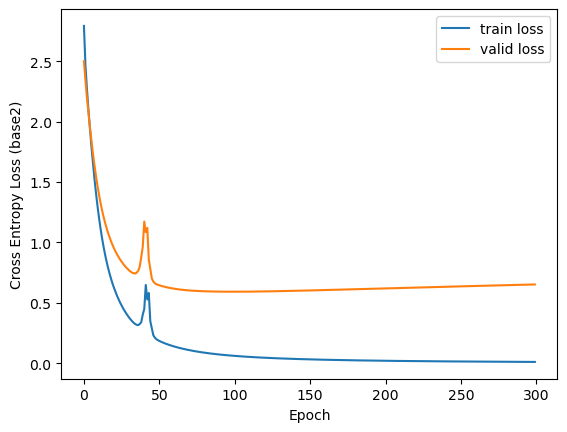

In [67]:
plt.plot(history_df['loss'], label='train loss')
plt.plot(history_df['val_loss'], label='valid loss')
plt.legend(loc='upper right');

plt.ylabel('Cross Entropy Loss (base2)');
plt.xlabel('Epoch');


**Exercise**

TODO: Can you add L2 regularization to try to do better in terms of validation cross-entropy loss?
